<a href="https://colab.research.google.com/github/Ssanyachetwani/Sentiment-Analysis-for-Financial-News/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Processing HTML files and Extracting News Headlines

<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>getting the table that contains the headlines from each stock's HTML file</li>

In [3]:
from bs4 import BeautifulSoup
import os

html_tables = {}
for table_name in os.listdir('/content/datasets'):
    table_path = f'/content/datasets/{table_name}'
    table_file = open(table_path, 'r')
    html = BeautifulSoup(table_file)
    html_table = html.find(id='news-table')
    html_tables[table_name] = html_table

tsla = html_tables['tsla_22sep.html']
tsla_tr = tsla.findAll('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    
    link_text = table_row.a.get_text() 
    data_text = table_row.td.get_text()
   
    print(f'File number {i+1}:')
     
    print(link_text)
    print(data_text)
    if i == 3:
        break

parsed_news = []

for file_name, news_table in html_tables.items():
   
    for x in news_table.findAll('tr'):
        text = x.get_text()
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split("_")[0]
        parsed_news.append([ticker, date, time, x.a.text])

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 2. Using NLTK
<li>using NLTK to add some new words and sentiment values to the lexicon</li>
<li>programmatically predicting sentiment out of news headlines</li>

In [4]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
vader = SentimentIntensityAnalyzer()

vader.lexicon.update(new_words)

import pandas as pd
columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)

scores = [vader.polarity_scores(headline) for headline in scored_news.headline]
scores_df = pd.DataFrame(scores)
scored_news.columns = columns

scored_news = scored_news.join(scores_df)

scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Plotting all the sentiment in subplots
<p>Plotting the time series for the stocks we have.</p>

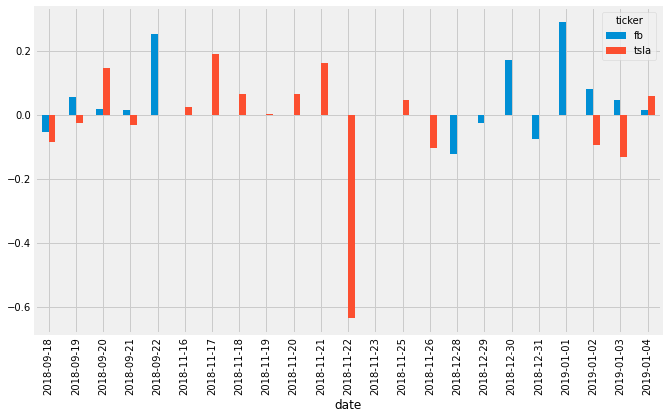

In [5]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline


mean_c = scored_news.groupby(['date', 'ticker']).mean()
mean_c = mean_c.unstack('ticker')
mean_c = mean_c.xs("compound", axis="columns")

mean_c.plot.bar(figsize = (10, 6));

## 4. Weekends and duplicates

<p>Case where two headlines are verbatim the same as another but from another news outlet. when one piece of news is more important, it tends to get more headlines from multiple sources. getting rid of duplicates.</p>

In [6]:
num_news_before = scored_news.headline.count()
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker'])
num_news_after = scored_news_clean.headline.count()

f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

## 8. Sentiment on one single trading day and stock
<p>focussing on one trading day and one single stock by making an informative plot where there is the smallest grain possible: headline and subscores.</p>

In [7]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])

single_day = single_day.xs('fb')
single_day = single_day.loc['2019-01-03']
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()

## 9. Visualize the single day
<p>making a plot to visualize the positive, negative and neutral scores for a single day of trading and a single stock.</p>

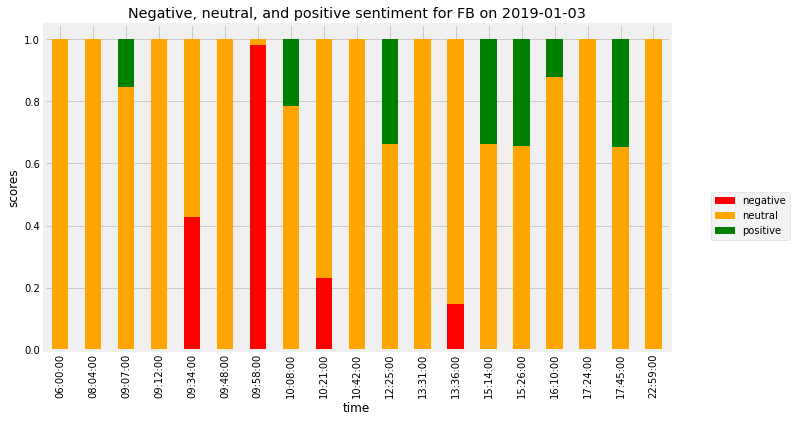

In [8]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2019-01-03"
COLORS = ["red","orange", "green"]

plot_day = single_day.drop(['compound', 'headline'], 1)
plot_day.columns = ['negative', 'neutral', 'positive']

# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");